In [59]:
import pandas as pd
import numpy as np
import pydot
import graphviz
import scipy
import matplotlib.pyplot
import tensorflow as tf
from tensorflow import keras, layers
from tensorflow.keras.layers import *

In [60]:
train_data = pd.read_csv('train.csv')

In [1]:
train_data.head()

In [90]:
train_data.fillna(0, inplace=True)

In [112]:


image = Input((256,256,1))

in1 = Conv2D(32,5, activation='relu', padding='same')(image)
in1 = MaxPooling2D((2,2), strides = (3,3))(in1)
in1 = Conv2D(64,3, strides = (3,3), activation='relu', padding='same')(in1)
in1 = MaxPooling2D((2,2), strides = (3,3))(in1)
in1 = Conv2D(128,3, strides = (3,3), activation='relu', padding='same')(in1)
in1 = MaxPooling2D((2,2), strides = (3,3))(in1)
in1 = Conv2D(128,3, activation='relu', padding='same')(in1)
#in1 = MaxPooling2D((2,2), strides = (3,3))(in1)
in1 = Flatten()(in1)

out1 = Dense(50, activation='relu')(in1)
out1 = Dropout(0.4)(out1)
out1 = Dense(15, activation='relu')(out1)
out1 = Dropout(0.4)(out1)
out1 = Dense(15, activation='relu')(out1)
out1 = Softmax(name='class_label')(out1)

out2 = Dense(50, activation='relu')(in1)
out2 = Dropout(0.4)(out2)
out2 = Dense(25, activation='relu')(out2)
out2 = Dropout(0.4)(out2)
out2 = Dense(4, activation='relu', name='bbox')(out2)

model2 = tf.keras.Model(inputs=image, outputs=[out1,out2])

model2.compile(optimizer='adam', loss={'class_label': 'sparse_categorical_crossentropy', 'bbox': 'mean_squared_error'}, 
               metrics=['accuracy'])

In [66]:
files = np.load('arrays.npz')

arrays = [files[key] for key in files]

In [67]:
nps=[]

for x in arrays:
    new = np.resize(x,(256,256))
    new = np.asarray(new)
    new = keras.preprocessing.image.img_to_array(new)
    nps.append(new)

In [92]:
ids = train_data.image_id.unique()

labels = []
boxes = []
for id_ in ids:
    df = train_data[train_data.image_id == id_]
    class_label = df.iloc[0,2]
    bbox = df.iloc[0,4:]
    #label = tf.io.decode_raw(label, tf.uint8)
    #label = tf.reshape(label, label.shape)
    #label = tf.one_hot(label, 10)
    labels.append(class_label)
    boxes.append(bbox)

In [96]:
class_labels, bbox_bound, data = np.random.shuffle(labels), np.random.shuffle(boxes), np.random.shuffle(nps)

In [97]:
class_labels = np.stack(labels)
bbox_bound = np.stack(boxes)
data = np.stack(nps)

In [110]:
X_train, X_test  = data[:12000], data[12000:]
y_lab_train, y_lab_test = class_labels[:12000], class_labels[12000:]
y_box_train, y_box_test = bbox_bound[:12000], bbox_bound[12000:]

In [113]:
model2.fit(X_train, [y_lab_train, y_box_train], epochs=5, batch_size=50, validation_split=0.2)

In [ ]:
model2.summary()

In [24]:
cls, b = model2.predict(X_test)

In [2]:
model2.evaluate(X_test, [y_lab_test, y_box_test])

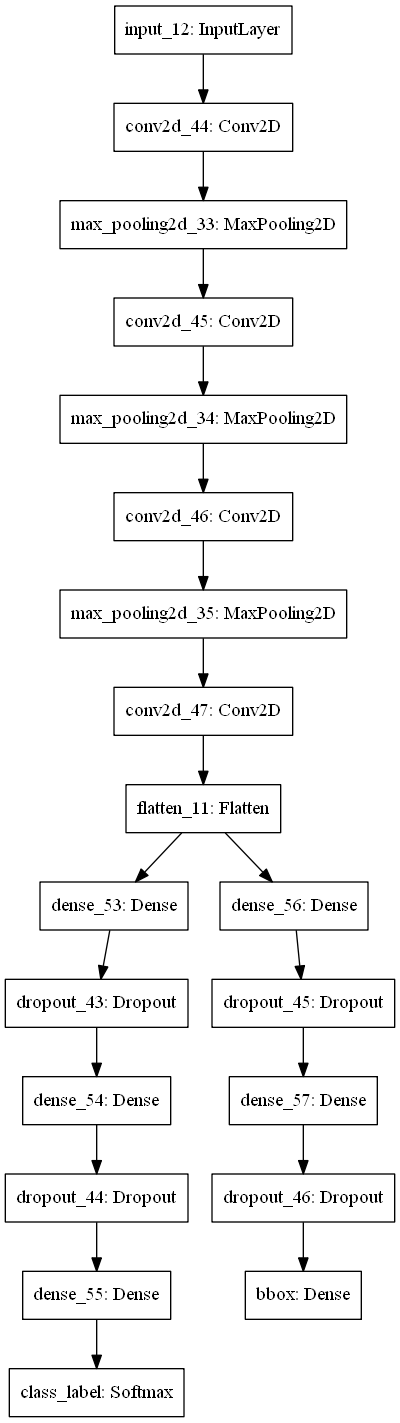

In [85]:
tf.keras.utils.plot_model(model2)